In [1]:
import os
import glob
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms.functional as TF
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.amp import autocast, GradScaler

In [11]:
# Set base directory (contains normal, benign, malignant folders)
base_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# Get ALL image-mask pairs from ALL classes
img_paths = []
mask_paths = []

# Process each class folder
class_folders = ['normal', 'benign', 'malignant']

for class_folder in class_folders:
    class_dir = os.path.join(base_dir, class_folder)
    
    # Check if folder exists
    if not os.path.exists(class_dir):
        print(f"Warning: {class_dir} not found, skipping...")
        continue
    
    print(f"Processing {class_folder}...")
    
    # Get all PNG files in this class folder
    for file in sorted(glob.glob(os.path.join(class_dir, '*.png'))):
        if '_mask' not in file:  # This is an image, not a mask
            img_paths.append(file)
            base = os.path.basename(file)[:-4]
            
            # Find corresponding mask(s) in SAME folder
            masks = sorted(glob.glob(os.path.join(class_dir, f'{base}*_mask*.png')))
            mask_paths.append(masks if masks else None)

# Filter valid pairs
valid_pairs = [(img, masks) for img, masks in zip(img_paths, mask_paths) if masks]
img_paths, mask_groups = zip(*valid_pairs)

print(f"\nFound {len(img_paths)} valid image-mask pairs from all classes")

# Split data
train_img, test_img, train_masks, test_masks = train_test_split(
    list(img_paths), list(mask_groups), train_size=0.8, random_state=7
)

print(f"Training samples: {len(train_img)}")
print(f"Testing samples: {len(test_img)}")

# Transforms
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform = T.Compose([ # Geometric augmentations 
    T.ColorJitter(brightness=0.2, contrast=0.2), # vary brightness/contrast 
    T.RandomAdjustSharpness(sharpness_factor=2, p=0.3), # simulate sharper/blurred scans # Convert to tensor and normalize 
    T.ToTensor(), 
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])



Processing normal...
Processing benign...
Processing malignant...

Found 780 valid image-mask pairs from all classes
Training samples: 624
Testing samples: 156


In [12]:
class BUSIDataset(Dataset):
    def __init__(self, img_paths, mask_groups, transform=None, size=256):
        self.img_paths = img_paths
        self.mask_groups = mask_groups
        self.transform = transform
        self.size = size
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        # Load and resize image
        img = Image.open(self.img_paths[idx]).convert('RGB').resize((self.size, self.size))
        
        # Load and combine masks
        mask_combined = None
        for mask_path in self.mask_groups[idx]:
            mask = Image.open(mask_path).convert('L').resize((self.size, self.size))
            mask = np.array(mask, dtype=np.float32)
            mask = (mask > 127.0).astype(np.float32)
            
            if mask_combined is None:
                mask_combined = mask
            else:
                mask_combined = np.maximum(mask_combined, mask)
        
        # Apply transform to image
        if self.transform:
            img = self.transform(img)
        
        # Convert mask to tensor
        mask_tensor = torch.from_numpy(mask_combined).unsqueeze(0)
        
        return img, mask_tensor


In [13]:
# Create datasets
train_dataset = BUSIDataset(train_img, train_masks, transform=train_transform)
test_dataset = BUSIDataset(test_img, test_masks, transform=test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, num_workers=2, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=2, pin_memory=True, shuffle=False)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 78
Test batches: 20


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [15]:
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels,dropout=0.0):
      super().__init__()
      self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
         )

    def forward(self, x):
        return self.double_conv(x)
        
class UNET(nn.Module):
     def __init__(self, in_channels=3, out_channels=1, features=[32,64,128,256]):
         super().__init__()
         self.ups = nn.ModuleList()
         self.downs = nn.ModuleList()
         self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

         for feature in features:
             self.downs.append(DoubleConv(in_channels,feature))
             in_channels = feature

         for feature in reversed(features):
             self.ups.append(nn.ConvTranspose2d(feature*2,feature,kernel_size=2,stride=2))
             self.ups.append(DoubleConv(feature*2,feature, dropout=0.3))
             
         self.bottleneck = DoubleConv(features[-1],features[-1]*2,  dropout = 0.5)
         self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

     def forward(self,x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.Resize(x , size=skip_connection[2:])
            concats = torch.cat((x,skip_connection), dim=1)
            x = self.ups[idx+1](concats)
        return self.final_conv(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Image batch: torch.Size([8, 3, 256, 256])
Mask batch: torch.Size([8, 1, 256, 256])


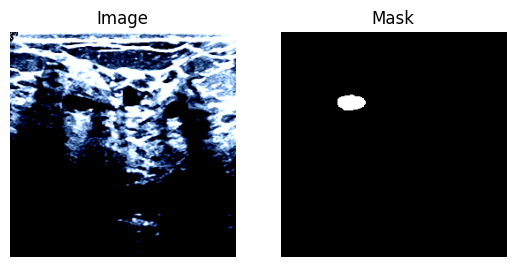

In [19]:
for img, mask in train_loader:
    print("Image batch:", img.shape) # [B, 3, H, W] 
    print("Mask batch:", mask.shape) # [B, 1, H, W] 
    plt.subplot(1, 2, 1) 
    plt.imshow(img[0].permute(1, 2, 0).cpu()) 
    plt.title("Image") 
    plt.axis("off")
    
    plt.subplot(1, 2, 2) 
    plt.imshow(mask[0,0].cpu(), cmap="gray") 
    plt.title("Mask") 
    plt.axis("off") 
    plt.show()
    # optional: break if you only want the first batch
    break

In [20]:
def DiceLoss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)  # flattening to convert (B,c,256,256) into B*C*256*256 Flattening ensures we’re comparing every pixel in the batch as part of one big set, instead of trying to compute Dice per dimension.
    target = target.view(-1)
    intersection = (pred*target).sum()
    dice_score = (2*intersection+smooth)/(pred.sum()+target.sum()+smooth)
    return 1-dice_score

def DiceScore(pred, target, smooth=1e-6):
    pred =(pred>0.5).float()
    target = target.float()
    intersection = (pred*target).sum()
    dice_score = (2*intersection+smooth)/(pred.sum()+target.sum()+smooth)
    return dice_score

In [21]:
model = UNET()  # Sneaky () here 
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
scaler = GradScaler('cuda')

In [23]:
epochs = 100
train_losses=[]
test_losses=[]
train_dice=[]
test_dice=[]
patience = 10 # how many epochs to wait before stopping 
best_val_dice = 0 # initialize with 0 (or -inf if you prefer) 
epochs_no_improve = 0 # counter for epochs without improvement
 
for epoch in range(epochs):
    dice_score_trains = 0 # bahira rakh yeslai 
    loss_trains = 0
    model.train()
    for img,mask in train_loader:
        img,mask = img.to(device), mask.to(device).float()
        optimizer.zero_grad()

        # Calcualte loss in fp-16
        with autocast('cuda'):
           output = model(img)
           dice_loss = DiceLoss(output, mask)
           bce_loss = criterion(output, mask)
           loss = dice_loss+bce_loss

        # Back prop
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Sneaky _ here & it prevents exploding gradients
        scaler.step(optimizer)
        scaler.update()
        
        # Dice score after back prop to minimize computational cost
        probs = torch.sigmoid(output)
        dice_score_train = DiceScore(probs, mask)
        
        dice_score_trains +=  dice_score_train.item()
        loss_trains += loss.item()
        
    avg_dice_train = dice_score_trains/len(train_loader)
    avg_train_loss = loss_trains/len(train_loader)

    # Evaluating Loop
    dice_score_tests = 0 
    loss_tests = 0
    model.eval()
    with torch.no_grad(): # grads haina muji
        for img,mask in test_loader:
            img,mask = img.to(device), mask.to(device).float()  # Mask floating for BCE Loss
            
            with autocast('cuda'):
               output = model(img)
               dice_loss = DiceLoss(output, mask)
               bce_loss = criterion(output, mask)
               loss = dice_loss+bce_loss

            probs = torch.sigmoid(output)
            dice_score_test = DiceScore(probs, mask)
            dice_score_tests +=  dice_score_test.item()
            loss_tests += loss.item()
        
    avg_dice_test = dice_score_tests/len(test_loader) # Align with with.torch.no_grad()
    avg_test_loss = loss_tests/len(test_loader)

    scheduler.step()

    # Only for graphhing
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_dice.append(avg_dice_train)
    test_dice.append(avg_dice_test)


    # for printing
    print(f'epoch:{epoch+1}')
    print(f"  Train - Loss: {avg_train_loss:.4f}, Dice: {avg_dice_train:.4f}")
    print(f"  Val   - Loss: {avg_test_loss:.4f}, Dice: {avg_dice_test:.4f}")

    if avg_dice_test > best_val_dice:
        best_val_dice = avg_dice_test
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

epoch:1
  Train - Loss: 1.5296, Dice: 0.1623
  Val   - Loss: 1.3871, Dice: 0.1142
epoch:2
  Train - Loss: 1.3655, Dice: 0.2486
  Val   - Loss: 1.3210, Dice: 0.3706
epoch:3
  Train - Loss: 1.2773, Dice: 0.4683
  Val   - Loss: 1.2198, Dice: 0.4880
epoch:4
  Train - Loss: 1.2302, Dice: 0.5216
  Val   - Loss: 1.2519, Dice: 0.4499
epoch:5
  Train - Loss: 1.1910, Dice: 0.5428
  Val   - Loss: 1.1060, Dice: 0.5941
epoch:6
  Train - Loss: 1.1351, Dice: 0.5742
  Val   - Loss: 1.0531, Dice: 0.6317
epoch:7
  Train - Loss: 1.0844, Dice: 0.6041
  Val   - Loss: 1.0266, Dice: 0.6270
epoch:8
  Train - Loss: 1.0437, Dice: 0.6127
  Val   - Loss: 1.0561, Dice: 0.5567
epoch:9
  Train - Loss: 1.0100, Dice: 0.6270
  Val   - Loss: 0.9672, Dice: 0.6459
epoch:10
  Train - Loss: 0.9668, Dice: 0.6573
  Val   - Loss: 0.9083, Dice: 0.6980
epoch:11
  Train - Loss: 0.9314, Dice: 0.6795
  Val   - Loss: 0.8888, Dice: 0.6819
epoch:12
  Train - Loss: 0.8992, Dice: 0.6895
  Val   - Loss: 0.8690, Dice: 0.6990
epoch:13
  Tr

<function matplotlib.pyplot.show(close=None, block=None)>

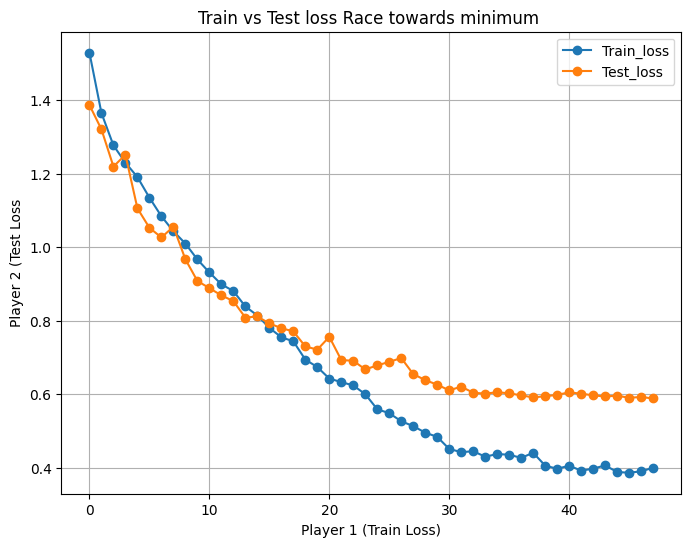

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train_loss', marker='o')
plt.plot(test_losses, label ='Test_loss', marker='o')
plt.title('Train vs Test loss Race towards minimum ')
plt.xlabel('Player 1 (Train Loss)')
plt.ylabel('Player 2 (Test Loss')
plt.grid(True)
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

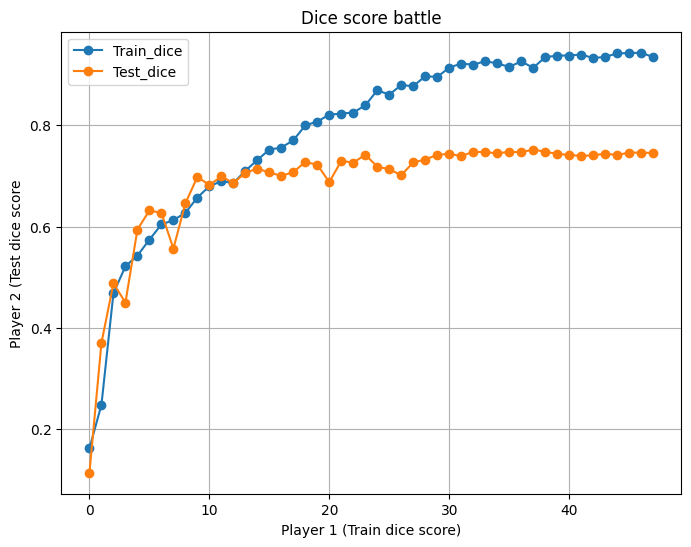

In [25]:
plt.figure(figsize=(8,6))
plt.plot(train_dice, label='Train_dice', marker='o')
plt.plot(test_dice, label ='Test_dice', marker='o')
plt.title('Dice score battle')
plt.xlabel('Player 1 (Train dice score)')
plt.ylabel('Player 2 (Test dice score')
plt.grid(True)
plt.legend()
plt.show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.4308496].


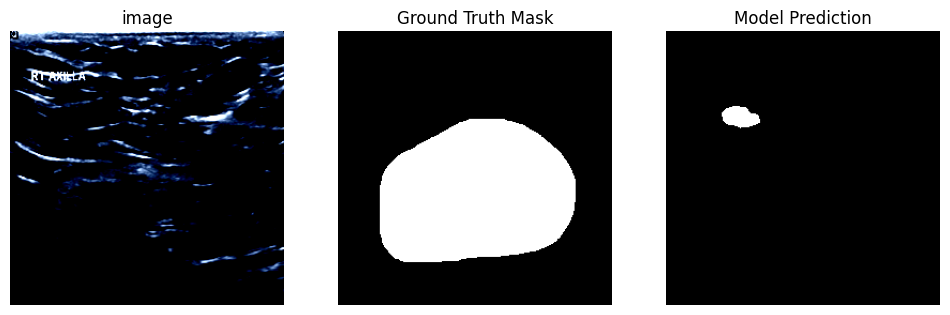

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


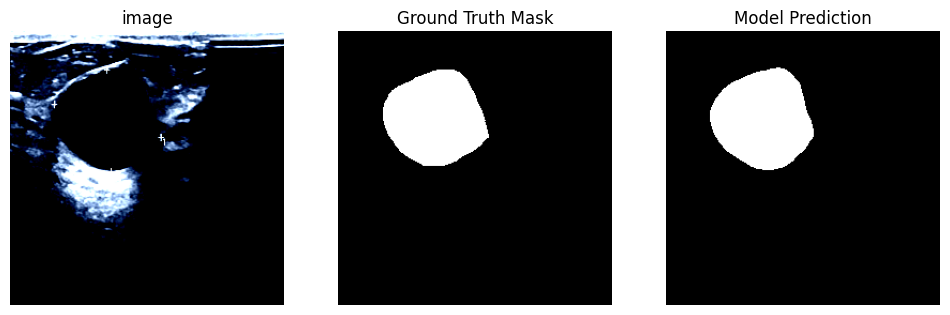

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3088455].


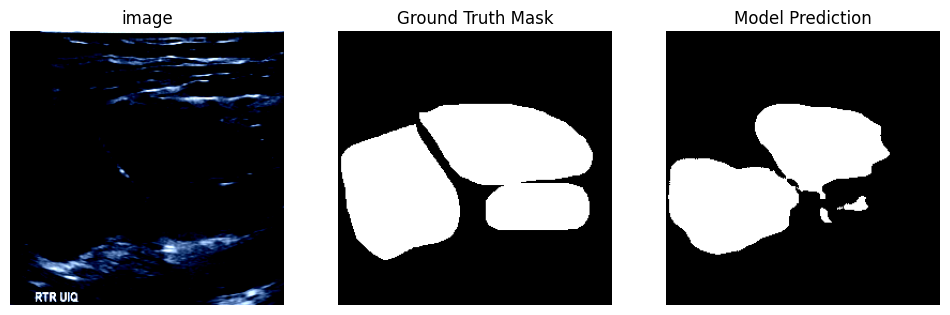

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.64].


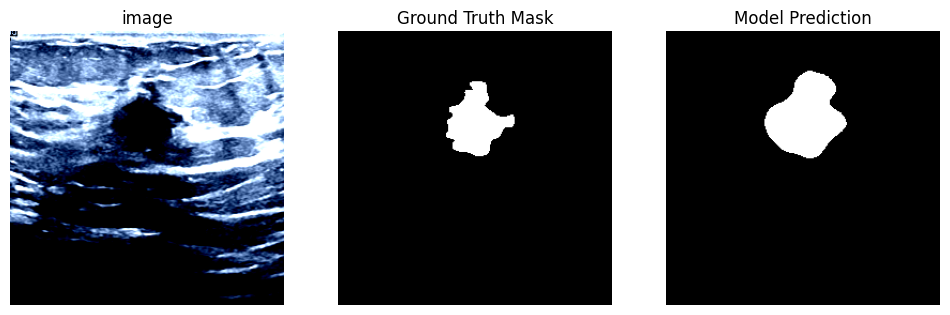

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


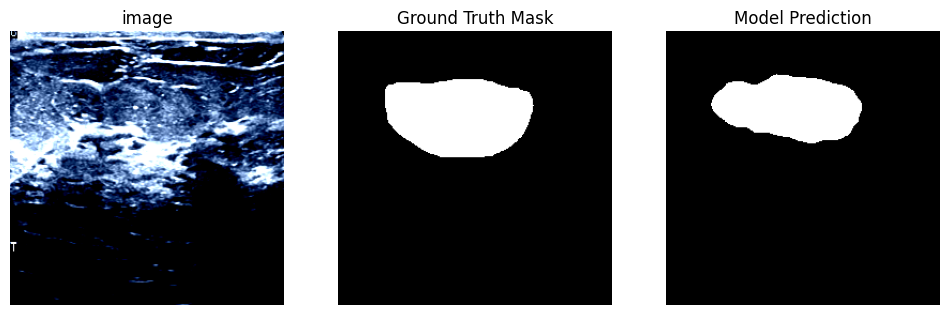

In [31]:
num_images = 5
model.eval()
with torch.no_grad():
    for i, (img,msk) in enumerate(test_loader):
        if i>= num_images:
            break

        img,msk = img.to(device), msk.to(device).float()

        # Algorithm
        output = model(img)
        probs = torch.sigmoid(output)
        preds = (probs>0.5).float()

        # Convert tensor to cpu numpy
        image = img[0].permute(1,2,0).cpu().numpy() # Shape goes from [B, C, H, W] → [C, H, W]. Then you do permute to reorder it into [H, W, C] for Matplotlib.
        mask = msk[0,0].cpu().numpy() # [H,W]=[0,0]
        pred = preds[0,0].cpu().numpy()

        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title('image')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(mask, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")
        
        plt.subplot(1,3,3)
        plt.imshow(pred, cmap="gray")
        plt.title("Model Prediction")
        plt.axis("off")
        
        plt.show()